In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from modules import *
from sim import *
from read_ramses import *


In [174]:
# choose simulation
sim_round = 8
sim_name = "bturbfunc"
sim_dir = move_to_sim_dir(sim_round, sim_name)
sim_latex = sim_name_to_latex[sim_name]
print()

dump = get_dump(a_exp=0.1)
info = get_info(dump)

print("Dump: %d" % dump)
print("a_exp: %.3g" % info.a_exp)
print("Maximum AMR level: %d" % info.amr_level_max)


Moving to directory '/home/za9132/scratch/romain/round8/bturbfunc'.

Dump: 27
a_exp: 0.0794
Maximum AMR level: 13


In [175]:
starbirth_cat = SimpleNamespace(**np.load("stardeath.npz")) #SimpleNamespace(**np.load("starbirth.npz"))
stardeath_cat = SimpleNamespace(**np.load("stardeath.npz"))


Text(0.5, 1.0, 'Variable $b_{\\rm turb}$')

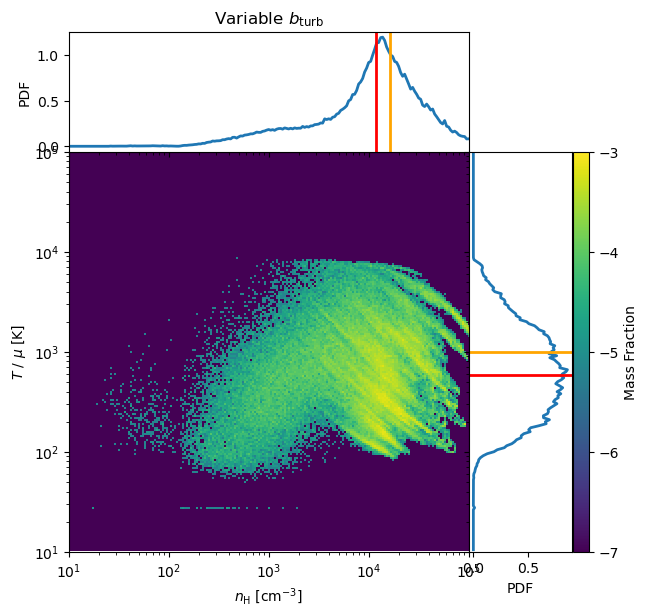

In [176]:
nbins = 200
n_H_extrema = (1e1, 1e5)
temp_extrema = (1e1, 1e5)
mass_frac_extrema = (1e-7, 1e-3)
time = 500 * const.Myr

star_cat = starbirth_cat
cond = star_cat.time <= time

fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_axes([0, 0, 1, 1])

n_H = const.X_cosmo * star_cat.density / const.m_H
temp = stardeath_cat.temperature

n_H_2d, temperature_2d, mass_2d = calc_phase(n_H[cond], temp[cond], n_H_extrema, temp_extrema, nbins=nbins, weight=star_cat.mass[cond])
mass_frac_2d = mass_2d / np.sum(star_cat.mass[cond])
im = ax1.pcolormesh(n_H_2d, temperature_2d, np.log10(mass_frac_2d + epsilon), vmin=np.log10(mass_frac_extrema[0]), vmax=np.log10(mass_frac_extrema[1]))

ax1.set_xlabel(r"$n_{\rm H}$ [${\rm cm^{-3}}$]")
ax1.set_ylabel(r"$T~/~\mu$ [K]")
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(*n_H_extrema)
ax1.set_ylim(*temp_extrema)

ax2 = fig.add_axes([0, 1, 1, 0.3], sharex=ax1)
plt.setp(ax2.get_xticklabels(), visible=False)
plot_pdf(n_H[cond], ax=ax2, extrema=n_H_extrema, weights=star_cat.mass[cond], do_log=True, do_axes_labels=False, nbins=nbins, show_median=True, show_mean=True)
ax2.set_ylabel("PDF")

ax3 = fig.add_axes([1, 0, 0.3, 1], sharey=ax1)
plt.setp(ax3.get_yticklabels(), visible=False);
plot_pdf(temp[cond], ax=ax3, extrema=temp_extrema, weights=star_cat.mass[cond], do_log=True, do_axes_labels=False, nbins=nbins, flip_axes=True, show_median=True, show_mean=True)
ax3.set_xlabel("PDF")

cbar_ticks = np.arange(np.log10(mass_frac_extrema[0]), np.log10(mass_frac_extrema[1])+1)
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="15%", pad=0.01)
plt.colorbar(im, ax=ax1, cax=cax, ticks=cbar_ticks, label=r"Mass Fraction")

ax2.set_title(sim_latex)

# save_fig("starbirth-bturb1p0")


Text(0.5, 1.0, 'Variable $b_{\\rm turb}$')

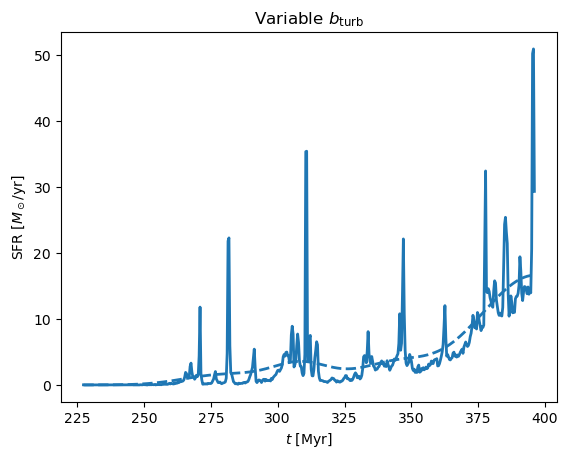

In [177]:
nbins = 500
filter_sigma = 10 * const.Myr

counts, bins = np.histogram(starbirth_cat.time, bins=nbins, weights=starbirth_cat.mass)

star_birthtime_1d = bins[:-1] + np.diff(bins)[0]
star_mass_1d = counts
SFR_mass_1d = star_mass_1d / np.diff(bins)[0]

filter_sigma_idx = filter_sigma / np.diff(star_birthtime_1d)[0]
SFR_mass_1d_smoothed = gaussian_filter(SFR_mass_1d, sigma=filter_sigma_idx)

plt.plot(star_birthtime_1d / const.Myr, SFR_mass_1d / const.M_sol * const.yr, lw=2, alpha=1., label=sim_latex, color='C0')
plt.plot(star_birthtime_1d / const.Myr, SFR_mass_1d_smoothed / const.M_sol * const.yr, lw=2, alpha=1., label=sim_latex, color='C0', linestyle='--')

plt.ylabel(r"SFR [$M_\odot / {\rm yr}$]")
plt.xlabel(r"$t$ [Myr]")

plt.title(sim_latex)

# save_fig("SFR-dxmin")


### simulation comparison


Moving to directory '/home/za9132/scratch/romain/round8/bturb0p3'.
Moving to directory '/home/za9132/scratch/romain/round8/bturb1p0'.
Moving to directory '/home/za9132/scratch/romain/round8/bturbfunc'.


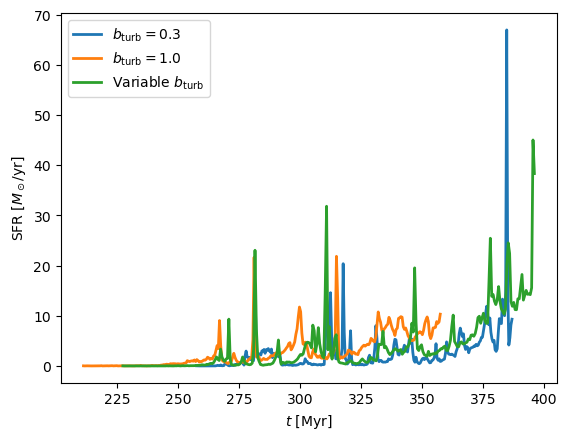

In [145]:
sim_round = 8
list_of_sim_name = ["bturb0p3", "bturb1p0", "bturbfunc"]
nbins = 300
filter_sigma = 10 * const.Myr

for i, sim_name in enumerate(list_of_sim_name):

    sim_dir = move_to_sim_dir(sim_round, sim_name)
    sim_latex = sim_name_to_latex[sim_name]
    
    starbirth_cat = SimpleNamespace(**np.load("stardeath.npz")) #SimpleNamespace(**np.load("starbirth.npz"))
    stardeath_cat = SimpleNamespace(**np.load("stardeath.npz"))

    counts, bins = np.histogram(starbirth_cat.time, bins=nbins, weights=starbirth_cat.mass)

    star_birthtime_1d = bins[:-1] + np.diff(bins)[0]
    star_mass_1d = counts
    SFR_mass_1d = star_mass_1d / np.diff(bins)[0]

    filter_sigma_idx = filter_sigma / np.diff(star_birthtime_1d)[0]
    SFR_mass_1d_smoothed = gaussian_filter(SFR_mass_1d, sigma=filter_sigma_idx)

    plt.plot(star_birthtime_1d / const.Myr, SFR_mass_1d / const.M_sol * const.yr, lw=2, alpha=1., label=sim_latex, color='C%d' % i)
    #plt.plot(star_birthtime_1d / const.Myr, SFR_mass_1d_smoothed / const.M_sol * const.yr, lw=2, alpha=1., color='C%d' % i, linestyle='--')

    plt.ylabel(r"SFR [$M_\odot / {\rm yr}$]")
    plt.xlabel(r"$t$ [Myr]")
    plt.legend()
    
# save_fig("SFR-comparison-fixedloc")


Moving to directory '/home/za9132/scratch/romain/round8/bturb0p3'.
Moving to directory '/home/za9132/scratch/romain/round8/bturb1p0'.
Moving to directory '/home/za9132/scratch/romain/round8/bturbfunc'.
Moving to directory '/home/za9132/scratch/romain/round8/bturbfunc_jeans'.


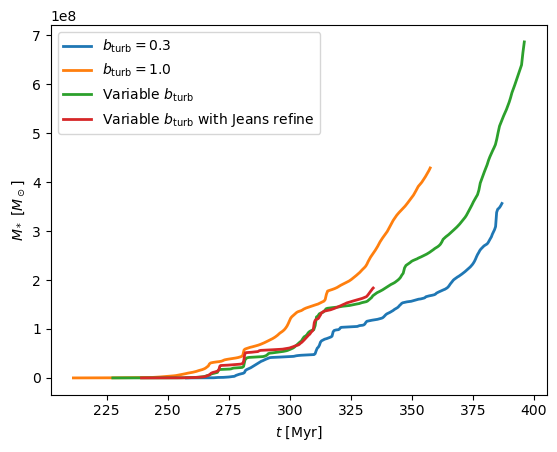

In [146]:
sim_round = 8
list_of_sim_name = ["bturb0p3", "bturb1p0", "bturbfunc", "bturbfunc_jeans"]
nbins = 300
filter_sigma = 10 * const.Myr

for i, sim_name in enumerate(list_of_sim_name):

    sim_dir = move_to_sim_dir(sim_round, sim_name)
    sim_latex = sim_name_to_latex[sim_name]
    
    starbirth_cat = SimpleNamespace(**np.load("stardeath.npz")) #SimpleNamespace(**np.load("starbirth.npz"))
    stardeath_cat = SimpleNamespace(**np.load("stardeath.npz"))

    counts, bins = np.histogram(starbirth_cat.time, bins=nbins, weights=starbirth_cat.mass)

    star_birthtime_1d = bins[:-1] + np.diff(bins)[0]
    star_mass_1d = counts
    star_mass_cum = np.cumsum(star_mass_1d)

    filter_sigma_idx = filter_sigma / np.diff(star_birthtime_1d)[0]
    plt.plot(star_birthtime_1d / const.Myr, star_mass_cum / const.M_sol, lw=2, alpha=1., label=sim_latex, color='C%d' % i)

plt.ylabel(r"$M_*$ [$M_\odot$]")
plt.xlabel(r"$t$ [Myr]")
# plt.yscale('log')
plt.legend()
    
#save_fig("SFR-comparison")
